In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:

# Load the dataset
df = pd.read_csv('/content/AMZN.csv')

# Use more features
df = df[['Close', 'Open', 'High', 'Low', 'Volume']]

# Calculate moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# Drop NaN values
df = df.dropna()

# Normalization of data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Preparing the dataset
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])  # Assuming the first column is the target
    return np.array(X), np.array(y)

time_steps = 30  # Increased time steps
X, y = create_dataset(scaled_data, time_steps)

# Splitting data into training and testing sets
split_ratio = 0.8
split = int(len(X) * split_ratio)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:

# Define the XCM model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Multiple convolutional layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
conv1 = Conv1D(filters=128, kernel_size=3, activation='relu')(conv1)
pool1 = MaxPooling1D(pool_size=2)(conv1)
dropout1 = Dropout(0.2)(pool1)

conv2 = Conv1D(filters=128, kernel_size=3, activation='relu')(dropout1)
conv2 = Conv1D(filters=256, kernel_size=3, activation='relu')(conv2)
pool2 = MaxPooling1D(pool_size=2)(conv2)
dropout2 = Dropout(0.2)(pool2)

# Flatten the layer
flat = Flatten()(dropout2)

# Fully connected layers
fc1 = Dense(128, activation='relu')(flat)
dropout3 = Dropout(0.3)(fc1)
fc2 = Dense(64, activation='relu')(dropout3)

# Output layer
output_layer = Dense(1)(fc2)

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 2.2650e-04 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 2/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 4.9067e-05 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 3/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 4.5968e-05 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 4/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.6660e-05 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 5/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 3.4270e-05 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 6/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.0837e-05 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 7/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.1930e-05 - val_loss: 0.0046 - learning_rate: 2.0000e-04
Epoch 8/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.8985e-05 - val_loss: 0.0051 - learning_rate: 2.0000e-04
Epoch 9/100
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.

Test Loss: 0.012754134833812714
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 21.061779962682504
MAE: 18.965716335200618
MAPE: 15.745157278465374


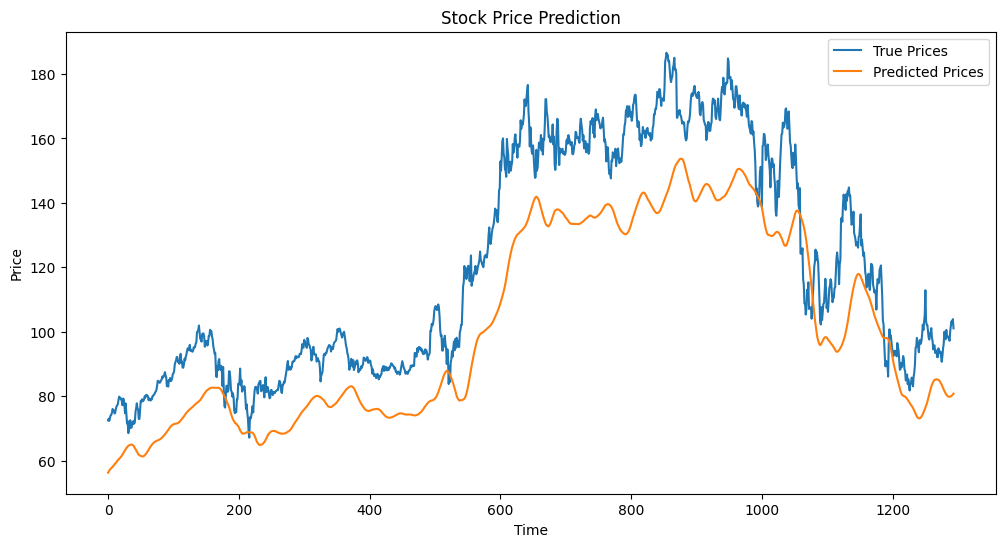

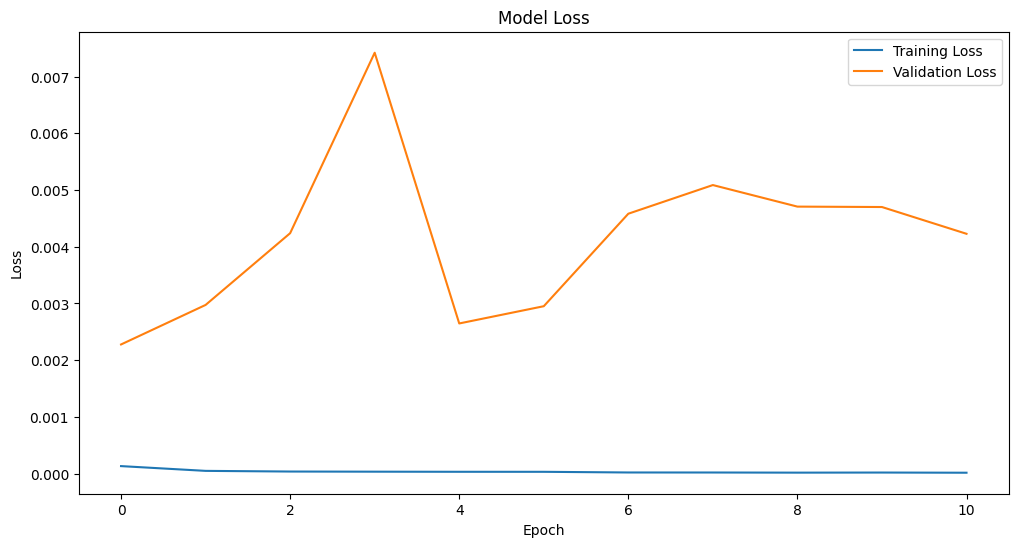

In [ ]:

# Evaluate and predict
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

predictions = model.predict(X_test)

# Inverse scaling
predictions_inverse = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], df.shape[1] - 1))], axis=1))[:, 0]
y_test_inverse = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], df.shape[1] - 1))], axis=1))[:, 0]

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
mape = np.mean(np.abs((y_test_inverse - predictions_inverse) / y_test_inverse)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Prices')
plt.plot(predictions_inverse, label='Predicted Prices')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()